In [1]:
import pandas as pd
import numpy as np
import glob, os
os.chdir("./train_images/train")


In [2]:
files = []
for file in glob.glob("*.tif"):
    files.append(file)

## Function to map images and its associated labels.
There is some issue while extracting the train 2.zip folder that won't extract all the images so this function will only extract labels of those images that are extracted. 

In [3]:
def extract_selected_labels(files):
    files = [files[i].split('.')[0] for i in range(len(files))]

    os.chdir('/mnt/disks/user/project/train_labels')
    data = pd.read_csv("train_labels.csv")
    filelist = []
    i= 1
    for file in files:
        filelist.append(np.where(data['id'].isin([file]))[0][0])
        print(i)
        i+=1
    df = data.iloc[filelist]
    return df
#df.to_csv("train_labels_selected.csv")

In [4]:
#df = extract_selected_labels(files)
#df.to_csv("train_labels_selected.csv")

In [5]:
df=pd.read_csv("/mnt/disks/user/project/train_labels/train_labels_selected.csv")
df.reset_index(inplace = True, drop = True)

In [6]:
df.head()

,Unnamed: 0,id,label
0,211458,a5708c12453f41a8f28e2fe4f302488b1f66de09,0
1,71650,f9223262312e495cfb221fd4acbff2e8715bde23,0
2,171360,7ada12a1316500a26b117913e1d9b0ac0432ab94,0
3,9664,598757e7ee350bb99625a50b2d4ee5860d90a673,0
4,215911,60eda16a67e9067fb861c66be2a928ee24b70d6d,0


In [7]:
df["image_paths"] = pd.Series(["/mnt/disks/user/project/train_images_alt/train/"+ str(df.loc[i,'id'])+".tif" for i in range(len(df))])
    
    

In [133]:
os.chdir('/mnt/disks/user/project/train_images_alt/train')
from PIL import Image
im = Image.open('7fedefabe3896790dc0f5df242ef26febd031bcd.tif')
im.show()

In [134]:
imarr = np.array(im)

### Viewing one component of the raw image

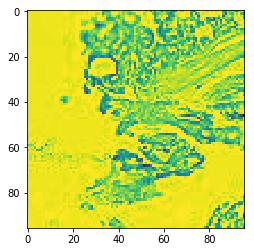

In [139]:
import matplotlib.pyplot as plt
plt.imshow(imarr[:,:,0])

### Viewing the cropped image 
The image is cropped to 48 by 48 pixels such that the important 36 by 36 is included 

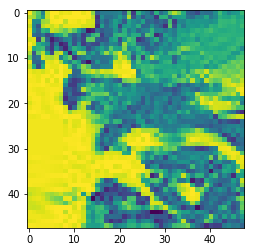

In [136]:
green = imarr[24:72,24:72,1]
plt.imshow(green)

In [137]:
####### Preparing dataset ###########
from skimage.io import imread
import os.path as path
#IMAGE_PATH = "/mnt/disks/user/project/trainimages/train/"+ str(file)
#file_paths = path.join(IMAGE_PATH, '*.tif')

In [25]:
############### Data Preparation ###################
#mapped_res = zip(images, np.array(df['label']))
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#X_train,X_test, y_train, y_test = train_test_split(images[0:10000], df['label'][0:10000], test_size = 0.1)

In [26]:
from tensorflow import set_random_seed

set_random_seed(42)
model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2),
                 activation='relu',
                 input_shape=(48,48,3)))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# Reading from folder and training model with augmentation 

## Function to crop the images: 
Its given that the tumors is only centered in the middle 36 pixels, an extra 6 pixels on all sides are taken as extra for precautions. Cropping images will reduce features 

In [ ]:
def exract_cropped_images():
    os.chdir('/mnt/disks/user/project/train_images/train')
    files = []
    for file in glob.glob("*.tif"):
        files.append(file)
    file_path = []    
    for file in files:    
        file_path.append("/mnt/disks/user/project/train_images_alt/train/"+ str(file))
    os.makedirs("cropped_images")
    i = 1
    for path, file  in zip(file_path,files):
        image = imread(path)
        cv2.imwrite(file,image[24:72,24:72,:])

        print(i)
        i+=1
        pass

## Dividing images into training and validation folders.
Each training and valdiations folder has two folders; one which has tumors and the other which does not!

In [27]:
import shutil
import os
def train_test_images_folders():
    os.chdir('/mnt/disks/user/project')

    shutil.rmtree('train_images_for_augment')   #to delete a folder
    shutil.rmtree('validation_images_for_augment')   #to delete a folder
    
    os.makedirs('train_images_for_augment')
    os.makedirs('validation_images_for_augment')
    os.chdir('/mnt/disks/user/project/train_images_for_augment')
    os.makedirs('has_tumor')
    os.makedirs('has_no_tumor')
    os.chdir('/mnt/disks/user/project/validation_images_for_augment')
    os.makedirs('has_tumor')
    os.makedirs('has_no_tumor')
    
    source = '/mnt/disks/user/project/cropped_images/'
    train_dest_tumors = '/mnt/disks/user/project/train_images_for_augment/has_tumor/'
    train_dest_notumors = '/mnt/disks/user/project/train_images_for_augment/has_no_tumor/'
    val_dest_tumors = '/mnt/disks/user/project/validation_images_for_augment/has_tumor/'
    val_dest_notumors = '/mnt/disks/user/project/validation_images_for_augment/has_no_tumor'


    for i in range(0,84311):
        if df.loc[i,'label'] == 1:
            shutil.move(source+df.loc[i,'id']+'.tif', train_dest_tumors)
        else:
            shutil.move(source+df.loc[i,'id']+'.tif', train_dest_notumors)


    for i in range(84311,len(df)):
        if df.loc[i,'label'] == 1:
            shutil.move(source+df.loc[i,'id']+'.tif', val_dest_tumors)
        else:
            shutil.move(source+df.loc[i,'id']+'.tif', val_dest_notumors)
    pass



In [28]:
#train_test_images_folders()

In [29]:
train_dest = '/mnt/disks/user/project/train_images_for_augment/'
validation_dest = '/mnt/disks/user/project/validation_images_for_augment/'

## Using Data Augmentation would improve the testing accuracy

In [30]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_length = 84311
batch = 512


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dest,
        target_size=(48, 48),
        batch_size=batch,
        class_mode='categorical')



Found 84311 images belonging to 2 classes.


In [31]:
validation_generator = test_datagen.flow_from_directory(
        validation_dest,
        target_size=(48, 48),
        batch_size=batch,
        class_mode='categorical')

model.fit_generator(
        train_generator,
        steps_per_epoch=train_length/batch,
        epochs=50,
        validation_data=validation_generator
        )

Found 4438 images belonging to 2 classes.
Epoch 1/50
165/164 [==============================] - 375s 2s/step - loss: 0.5451 - acc: 0.7209 - val_loss: 0.5247 - val_acc: 0.7530
Epoch 2/50
165/164 [==============================] - 371s 2s/step - loss: 0.4753 - acc: 0.7806 - val_loss: 0.5666 - val_acc: 0.7476
Epoch 3/50
165/164 [==============================] - 367s 2s/step - loss: 0.4490 - acc: 0.7957 - val_loss: 0.5052 - val_acc: 0.7706
Epoch 4/50
165/164 [==============================] - 361s 2s/step - loss: 0.4339 - acc: 0.8058 - val_loss: 0.4679 - val_acc: 0.7929
Epoch 5/50
165/164 [==============================] - 358s 2s/step - loss: 0.4170 - acc: 0.8170 - val_loss: 0.4445 - val_acc: 0.8049
Epoch 6/50
165/164 [==============================] - 358s 2s/step - loss: 0.4120 - acc: 0.8179 - val_loss: 0.4717 - val_acc: 0.7850
Epoch 7/50
165/164 [==============================] - 359s 2s/step - loss: 0.4067 - acc: 0.8216 - val_loss: 0.4451 - val_acc: 0.7963
Epoch 8/50
165/164 [=======

In [1]:
#model.save('my_model.h5')
from keras.models import load_model
model = load_model('/mnt/disks/user/project/my_model.h5')

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Reading images from validation folder
read the images and predict the classes 

In [4]:
import os, glob
def files_list_extract(path):
    os.chdir(path)
    files = []
    for file in glob.glob("*.tif"):
        files.append(path + str(file))
    return files

In [5]:
val_dest_tumors_path = '/mnt/disks/user/project/validation_images_for_augment/has_tumor/'
file_list_tumor = files_list_extract(val_dest_tumors_path)
val_dest_notumors_path = '/mnt/disks/user/project/validation_images_for_augment/has_no_tumor/'
file_list_notumor = files_list_extract(val_dest_notumors_path)
#file_list_tumor.extend(file_list_notumor)
#file_list = file_list_tumor

In [6]:
#images = [misc.imread(path) for path in all_img_paths]
def read_images_asarray(paths):
    images = []
    i = 1
    for path in paths:
        images.append(imread(path)[:,:,:])
        print(i)
        i+=1
    images = np.asarray(images)
    # Scale
    images = images / 255
    return images


In [11]:
from skimage.io import imread
import numpy as np
images_tumor = read_images_asarray(file_list_tumor)
images_notumor = read_images_asarray(file_list_notumor)
images = np.concatenate((images_tumor,images_notumor))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511


374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623


2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447


In [12]:
ypred = model.predict_classes(images)

In [13]:
tumor = np.ones(images_tumor.shape[0])
notumor = np.zeros(images_notumor.shape[0])
ytest = np.concatenate([tumor, notumor])

Confusion matrix, without normalization
[[2531  126]
 [ 600 1181]]


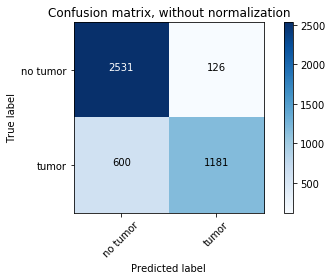

In [15]:
############### Plotting Confusion Matrix ##############
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = ['no tumor','tumor']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [16]:
np.trace(cnf_matrix)/sum(sum(cnf_matrix))

0.836412798557909

In [17]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.8078443538061295